# Using Convolutional Neural Networks

Welcome to the first week of the first deep learning certificate! We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning.

## Introduction to this week's task: 'Dogs vs Cats'

We're going to try to create a model to enter the [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats) competition at Kaggle. There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): *"**State of the art**: The current literature suggests machine classifiers can score above 80% accuracy on this task"*. So if we can beat 80%, then we will be at the cutting edge as of 2013!

## Basic setup

There isn't too much to do to get started - just a few simple configuration steps.

This shows plots in the web page itself - we always wants to use this when using jupyter notebook:

In [1]:
%matplotlib inline

Define path to data: (It's a good idea to put it in a subdirectory of your notebooks folder, and then exclude that directory from git control by adding it to .gitignore.)

In [22]:
root_path = "data/dogscats-redux/"
weights_path = root_path + 'keith_weights_1.h5'

#path = root_path
path = root_path + "sample/"

A few basic libraries that we'll need for the initial exercises:

In [3]:
from __future__ import division,print_function

import os, json, shutil, random, math
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

We have created a file most imaginatively called 'utils.py' to store any little convenience functions we'll want to use. We will discuss these as we use them.

In [4]:
import utils; reload(utils)
from utils import plots

Using cuDNN version 5103 on context None
Mapped name None to device cuda: Tesla K80 (1CC0:00:00.0)
Using Theano backend.


In [5]:
def predict_and_show(batches):
    imgs, labels = next(batches)
    preds, indexes, predicted_labels = vgg.predict(imgs)
    true_labels = [vgg.classes[idx] for idx in np.argmax(labels, axis=1)]
    plots(imgs, titles=['ok' if a == b else 'wrong' for (a,b) in zip(true_labels, predicted_labels)])

# Separating out the validation data
Create an 80/20 split of training data and validation data. It's important that they are distinct

**TODO** consider doing cross-validation so that we have more training data?

In [ ]:
def extract_validation_set_for_class(cls, parent_dir, validation_percentage):
    train_path = os.path.join(parent_dir, "train", cls) + '/'
    validation_path = os.path.join(parent_dir, "validation", cls) + '/'
    os.mkdir(validation_path)
    filenames = os.listdir(train_path)
    random.shuffle(filenames)
    validation_count = math.floor(validation_percentage * len(cat_filenames))
    print("Extracting {} random images from training class {}".format(validation_count, cls))
    for fname in filenames[:validation_count]:
        shutil.move(train_path + fname, validation_path + fname)

In [ ]:
if not os.path.exists(root_path + "validation"):
    for cls in os.listdir(root_path + "train"):
        extract_validation_set_for_class(cls, parent_dir, validation_percentage)

# Creating sample dataset
We want a small dataset for quick iteration on the code. The size should be on the order of 100 examples. It's ok if the full dataset overlaps with the sample dataset.

In [ ]:
def copy_dir_subset(source_dir, target_dir, count_to_keep):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    for fname in os.listdir(source_dir)[:count_to_keep]:
        shutil.copy(os.path.join(source_dir, fname), os.path.join(target_dir, fname))

In [ ]:
def create_small_dataset(full_dataset_path, small_dataset_path):
    """assumes that `root_path` contains directories named 'train' and 'validation' already"""
    (src, dest) = (full_dataset_path, small_dataset_path)
    classes = os.listdir(src + "train")
    for cls in classes:
        copy_dir_subset(src + "train/" + cls,      dest + "train/" + cls,      count_to_keep=80)
        copy_dir_subset(src + "validation/" + cls, dest + "validation/" + cls, count_to_keep=20)
    copy_dir_subset(src + "test/", dest + "test/", count_to_keep=80)

In [ ]:
if not os.path.exists(root_path + "sample"):
    create_small_dataset(root_path, root_path + "sample/")

## Use our Vgg16 class to finetune a Dogs vs Cats model

To change our model so that it outputs "cat" vs "dog", instead of one of 1,000 very specific categories, we need to use a process called "finetuning". Finetuning looks from the outside to be identical to normal machine learning training - we provide a training set with data and labels to learn from, and a validation set to test against. The model learns a set of parameters based on the data provided.

However, the difference is that we start with a model that is already trained to solve a similar problem. The idea is that many of the parameters should be very similar, or the same, between the existing model, and the model we wish to create. Therefore, we only select a subset of parameters to train, and leave the rest untouched. This happens automatically when we call *fit()* after calling *finetune()*.

We create our batches just like before, and making the validation set available as well. A 'batch' (or *mini-batch* as it is commonly known) is simply a subset of the training data - we use a subset at a time when training or predicting, in order to speed up training, and to avoid running out of memory.

In [10]:
batch_size=64

In [11]:
import vgg16; reload(vgg16)
vgg = vgg16.Vgg16()
batches = vgg.get_batches(path+'train', batch_size=batch_size)
validation_batches = vgg.get_batches(path+'validation', batch_size=batch_size)

using vgg16 weights & architecture
Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


Calling *finetune()* modifies the model such that it will be trained based on the data in the batches provided - in this case, to predict either 'dog' or 'cat'.

In [13]:
vgg.finetune(batches)

In [14]:
vgg.classes

['cats', 'dogs']

Finally, we *fit()* the parameters of the model using the training data, reporting the accuracy on the validation set after every epoch. (An *epoch* is one full pass through the training data.)

In [ ]:
vgg.fit(batches, validation_batches, nb_epoch=1)

In [ ]:
vgg.model.save_weights(weights_path)

# (Optional) Restore from Saved Weights

In [23]:
import vgg16; reload(vgg16)
if True:
    vgg = vgg16.Vgg16(weights_path)

using cats-vs-dogs


# Try it out

In [24]:
dummy_batches = vgg.get_batches(path+'train', batch_size=6)

Found 160 images belonging to 2 classes.


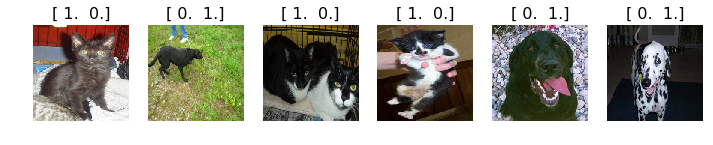

In [25]:
imgs, labels = next(dummy_batches)
plots(imgs, titles=labels)

In [26]:
vgg.predict(imgs)

(array([ 1.,  1.,  1.,  1.,  1.,  1.], dtype=float32),
 array([0, 1, 0, 0, 1, 1]),
 ['cats', 'dogs', 'cats', 'cats', 'dogs', 'dogs'])

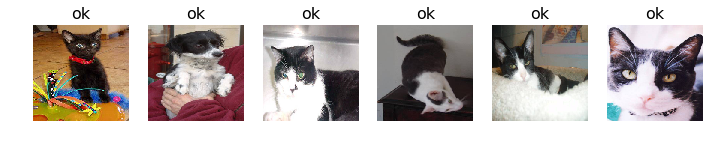

In [32]:
predict_and_show(dummy_batches)

# Generate Predictions over Test dataset

the `get_batches` function expects that the image files are wrapped in a category/class directory, so we will just use 'unknown' since the ground truth is not known for the test set. **do the following for the full dataset and the small dataset**:
```
mv test foo
mkdir test
mv foo test/unknown
```

In [ ]:
test_batches = vgg.get_batches(path+'test', batch_size=4, class_mode=None)

In [ ]:
vgg.predict(next(test_batches))

In [ ]:
predict_and_show(test_batches)

# Kaggle Submission

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def get_test_batches(path, batch_size):
    gen = ImageDataGenerator()
    return gen.flow_from_directory(path, target_size=(224,224), class_mode=None, shuffle=False, batch_size=batch_size)

In [ ]:
test_batches = get_test_batches(path + 'test', batch_size=8)

In [ ]:
dog_predictions = vgg.model.predict_generator(test_batches, test_batches.nb_sample)[:,1]
dog_predictions[:5]

Extract the id of each image in the test batch because Keras ImageDataGenerator will enumerate them in lexical order

In [ ]:
ids = [int(x.split("/")[1].split(".")[0]) for x in test_batches.filenames]
ids[:5]

fill out the submission table

In [ ]:
with open(root_path + 'keith_submission_1.csv', 'w') as f:
    f.write('id,label\n')
    for i in range(len(ids)):
        f.write('{},{}\n'.format(ids[i], dog_predictions[i]))